In [99]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

from PmtIDMap import PMTIDMap
from PlotDetectorGeometry import PlotBaseCircle
from collections import Counter
# map_pmt = PMTIDMap("/cvmfs/juno.ihep.ac.cn/centos7_amd64_gcc830/Pre-Release/J21v1r0-Pre2/offline/Simulation/DetSimV2/DetSimOptions/data/PMTPos_Acrylic_with_chimney.csv")
map_pmt = PMTIDMap("/cvmfs/juno.ihep.ac.cn/centos7_amd64_gcc830/Pre-Release/J21v1r0-Pre2/data/Simulation/ElecSim/PmtData_Lpmt.root")
v_R_xy = []
v_z = []
v_R_z_pmts = []
v_R_z_Ham_pmts = []
v_isHam = []
for i in range(map_pmt.n_pmt):
    xyz_pmt = map_pmt.idToXYZ(i)
    v_isHam.append(True if map_pmt.idToIsHam(i) else False)
    R_xy = round((xyz_pmt[0]**2+xyz_pmt[1]**2)**0.5*(1 if xyz_pmt[0]>0 else -1)/1e3,2)
    z_pmt = round(xyz_pmt[2]/1e3,2)
    v_R_xy.append(R_xy)
    v_z.append(z_pmt)
    v_R_z_pmts.append((R_xy, z_pmt))
    v_R_z_Ham_pmts.append((R_xy, z_pmt)) if v_isHam[-1] else 0
v_z = np.array(v_z)
v_R_xy = np.array(v_R_xy)
counter_R_z_pmts = Counter(v_R_z_pmts)
counter_R_z_Ham_pmts = Counter(v_R_z_Ham_pmts)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


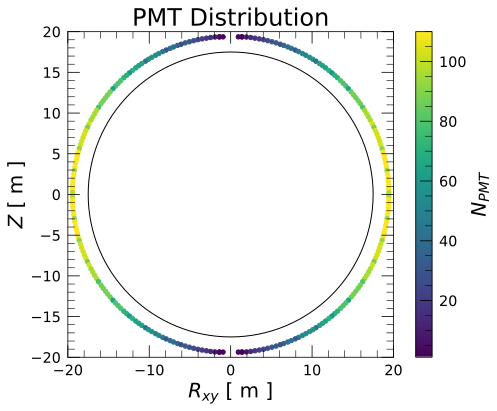

In [100]:
fig, ax = plt.subplots(1)
points_plot = np.array(list(counter_R_z_pmts.keys()))
x_plot = points_plot[:,0]
y_plot = points_plot[:,1]

c_plot = list(counter_R_z_pmts.values())

PlotBaseCircle(ax=ax)
c1 = ax.scatter(x_plot, y_plot,c=c_plot, s=20)
cbar = fig.colorbar(c1)
ax.set_title("PMT Distribution")
ax.set_xlabel("$R_{xy}$ [ m ]")
ax.set_ylabel("$Z$ [ m ]")
cbar.set_label("$N_{PMT}$")

In [101]:
from glob import glob
import os
name_source = "ACU/Co60"
data_basic_path = f"/afs/ihep.ac.cn/users/v/valprod0/Pre-Releases/J21v1r0-Pre2/11/{name_source}/"
# v_files_path = glob(f"{data_basic_path}Co60_0_0_[0-1]*")[:8]
v_files_path = glob(f"{data_basic_path}*_0_0_*")
v_position = [ os.path.basename(path) for path in v_files_path ]
v_position_y = np.array([float(position.split("_")[-2]) for position in v_position])
v_position_x = np.array([float(position.split("_")[-3]) for position in v_position])
v_position_z = np.array([float(position.split("_")[-1]) for position in v_position])

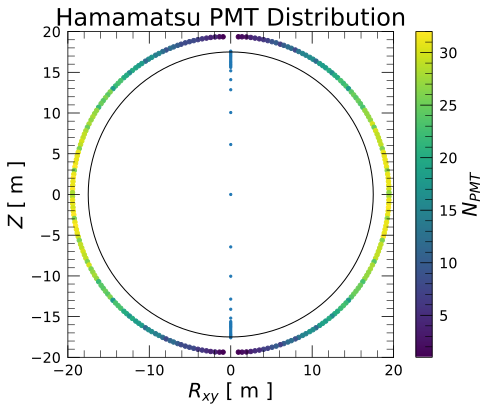

In [102]:
fig, ax = plt.subplots(1)
points_plot = np.array(list(counter_R_z_Ham_pmts.keys()))
x_plot = points_plot[:,0]
y_plot = points_plot[:,1]

c_plot = list(counter_R_z_Ham_pmts.values())

PlotBaseCircle(ax=ax)
c1 = ax.scatter(x_plot, y_plot,c=c_plot, s=20)
ax.scatter(np.sqrt(np.array(v_position_x)**2+np.array(v_position_y)**2)/1e3,
           v_position_z/1e3, s=5, label="ACU")
cbar = fig.colorbar(c1)
ax.set_title("Hamamatsu PMT Distribution")
ax.set_xlabel("$R_{xy}$ [ m ]")
ax.set_ylabel("$Z$ [ m ]")
cbar.set_label("$N_{PMT}$")

In [103]:
i_min = np.argmin(v_position_z)
v_xyz_source = np.array([v_position_x[i_min], v_position_y[i_min], v_position_z[i_min]])
v_R_z_source = np.array([v_R_xy[i_min], v_position_z[i_min]])/1000
v_cos_theta = []
v_d_pmt_to_source = []
for pmtid in range(map_pmt.n_pmt):
    v_xyz_pmt = map_pmt.idToXYZ(pmtid)
    v_d_pmt_to_source.append(np.sum( (v_xyz_source-v_xyz_pmt )**2 )**0.5/1000 )
    v_cos_theta.append(np.dot(v_xyz_source-v_xyz_pmt, -v_xyz_pmt)/\
                       (np.linalg.norm(v_xyz_pmt)*np.linalg.norm(v_xyz_source-v_xyz_pmt)))
v_cos_theta = np.array(v_cos_theta)
v_d_pmt_to_source = np.array(v_d_pmt_to_source)

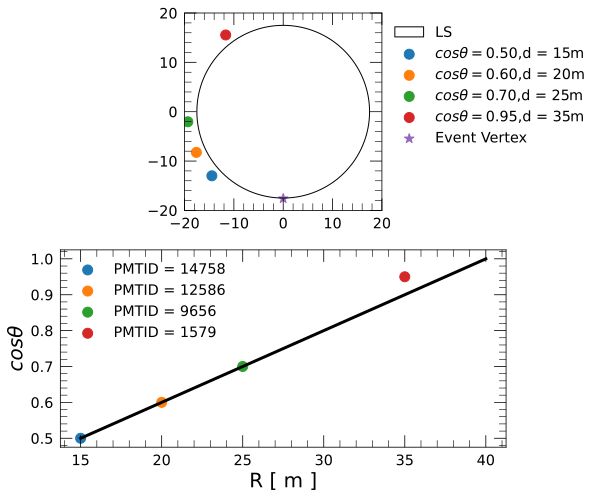

In [105]:
v_theta_d_pair = [(0.5, 15),(0.6, 20), (0.7,25),(0.95,35)]
v_pmtid_certain = []
v_pmt_cos_theta = []
v_pmt_d = []
fig, axes = plt.subplots(2,figsize=(8,8))
ax = axes[0]
ax_line = axes[1]
for pair in v_theta_d_pair:
    index_theta_60 = (np.abs(v_cos_theta-pair[0])<0.01) &\
                    (np.abs(v_d_pmt_to_source-pair[1])<0.2 )
    i_certain_pmt = np.where(index_theta_60)[0]
    v_pmtid_certain.append(i_certain_pmt[0])
    ax.scatter(v_R_xy[i_certain_pmt[0]], v_z[i_certain_pmt[0]], label=r"$cos\theta=$"+
                                                    f"{pair[0]:.2f},d = {pair[1]:.0f}m")
    ax_line.scatter(pair[1], pair[0], label=f"PMTID = {i_certain_pmt[0]}")
    v_pmt_d.append(pair[1])
    v_pmt_cos_theta.append(pair[0])
ax.scatter(v_R_z_source[0],v_R_z_source[1],s=100,marker="*", label="Event Vertex" )
ax_line.plot([15,40],[0.5,1],color="black")
ax_line.set_xlabel("R [ m ]")
ax_line.set_ylabel(r"$cos\theta$")
PlotBaseCircle(ax=ax)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax_line.legend()
# ax_line.set_aspect(1.0)

dir_save_pmts_certain = {"PMTID":v_pmtid_certain, "cos_theta":v_pmt_cos_theta,
                         "d_pmt_to_source":v_d_pmt_to_source}
np.savez("/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/PMTToPlot.npz", dir_pmt=dir_save_pmts_certain)

fig.savefig("/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/figure/PMTToPlot.png",bbox_inches='tight')
